In [1]:
from pitch_analysis_methods import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os, json
pd.set_option('display.max_rows', None) # None means no limit
from scipy.spatial.distance import euclidean


/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Select player (for now)
first_name = 'kyle'
last_name = 'freeland'
data = get_player_data(first_name, last_name)
pitch_types = get_player_pitch_types(data)
'Pitch Types:', pitch_types

Gathering player lookup table. This may take a moment.
Gathering Player Data


('Pitch Types:', ['SI', 'KC', 'FF', 'FC', 'CH', 'CU', 'ST'])

In [3]:
# Create directories/files
data_dir = './pitch_data'
os.makedirs(data_dir, exist_ok=True)
player_data_csv = os.path.join(data_dir, f'{last_name}_{first_name}.csv')

# Create MultiIndex
years = np.unique([date.split('-')[0] for date in data['game_date'].unique()])
mi = pd.MultiIndex.from_product([years, pitch_types, ['home', 'away']])
columns = ['no. thrown', 'usage', 'hb mean', 'hb std', 'ivb mean', 'ivb std', 'strike perc.', 'whiff perc.', 'BAA', 'SLGA', 'wOBAA', 'ISOA', 'BABIPA', 'dWE', 'dRE']

# Create DataFrame
df = pd.DataFrame([], index=mi, columns=columns)
df.head()

no. thrown usage hb mean hb std ivb mean ivb std strike perc.  \
2017 SI home        NaN   NaN     NaN    NaN      NaN     NaN          NaN   
        away        NaN   NaN     NaN    NaN      NaN     NaN          NaN   
     KC home        NaN   NaN     NaN    NaN      NaN     NaN          NaN   
        away        NaN   NaN     NaN    NaN      NaN     NaN          NaN   
     FF home        NaN   NaN     NaN    NaN      NaN     NaN          NaN   

             whiff perc.  BAA SLGA wOBAA ISOA BABIPA  dWE  dRE  
2017 SI home         NaN  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
        away         NaN  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
     KC home         NaN  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
        away         NaN  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
     FF home         NaN  NaN  NaN   NaN  NaN    NaN  NaN  NaN

In [7]:
# Put data into df
if not os.path.exists(player_data_csv):
    for i, year in enumerate(years):
        for j, pitch in enumerate(pitch_types):
            for k, loc in enumerate(['home', 'away']):
                parsed_data = parse_data(data, year=year, pitch=pitch, loc=loc)
    
                # Get no. thrown
                no_thrown = parsed_data.shape[0]
                if no_thrown > 0:
        
                    # Get usage
                    usage = 100 * no_thrown / parse_data(data, year=year, pitch=None, loc=loc).shape[0]
        
                    # Get horizantal break (hb)
                    hb = -parsed_data['pfx_x']*12
        
                    # Get induced vertical break (ivb)
                    ivb = parsed_data['pfx_z']*12
        
                    # Get strike percentage
                    strike_descr = ['called_strike', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip', 'foul_bunt', 'missed_bunt']
                    strike_perc = 100 * parsed_data[parsed_data['description'].isin(strike_descr)].shape[0] / no_thrown
        
                    # Get whiff percentage
                    whiff_descr = ['swinging_strike', 'swinging_strike_blocked']
                    whiff_perc = 100 * parsed_data[parsed_data['description'].isin(whiff_descr)].shape[0] / no_thrown
        
                    # Get BAA
                    hit_descr = ['single', 'double', 'triple', 'home_run']
                    at_bats_descr = ['force_out', 'single', 'field_out', 'strikeout', 'double', 'home_run', 'triple', 'grounded_into_double_play', 'double_play', 'strikeout_double_play']
                    no_ab = parsed_data[parsed_data['events'].isin(at_bats_descr)].shape[0]
                    BAA = parsed_data[parsed_data['events'].isin(hit_descr)].shape[0] / no_ab
                    
                    # Get SLGA (Slugging Against)
                    no_singles, no_doubles, no_triples, no_homeruns = [parsed_data[parsed_data['events'] == descr].shape[0] for descr in hit_descr]
                    SLGA = ((no_singles * 1) + (no_doubles * 2) + (no_triples * 3) + (no_homeruns * 4)) / no_ab
        
                    # wOBA against 
                    wOBAA = parsed_data['woba_value'].mean()
        
                    # ISO against
                    no_singles, no_doubles, no_triples, no_homeruns = [parsed_data[parsed_data['events'] == descr].shape[0] for descr in hit_descr]
                    ISOA = ((no_doubles * 2) + (no_triples * 3) + (no_homeruns * 4)) / no_ab
                    
                    # BABIP aginst
                    no_strikeouts = parsed_data[parsed_data['events'] == 'strikeouts'].shape[0]
                    no_sac_flies = parsed_data[parsed_data['events'] == 'sac_fly'].shape[0]
                    nom = no_singles + no_doubles + no_triples
                    denom = no_ab - no_strikeouts - no_homeruns + no_sac_flies
                    BABIPA = nom / denom
        
                    # Delta win expectancy 
                    if loc == 'home':
                        dWE = parsed_data['delta_home_win_exp'].sum() * 100
                    else:
                        dWE = -parsed_data['delta_home_win_exp'].sum() * 100
        
                    # Delta run expectancy
                    dRE = parsed_data['delta_run_exp'].sum() * 100
    
                    # Add to table
                    values = np.array([no_thrown, usage, hb.mean(), hb.std(), ivb.mean(), ivb.std(), strike_perc, whiff_perc, BAA, SLGA, wOBAA, ISOA, BABIPA, dWE, dRE])
                    # print(df.loc[year,pitch,loc].shape, values.shape)
                    df.loc[year, pitch, loc] = values
    # Write csv
    df.to_csv(player_data_csv)

else:
    # Read csv
    df = pd.read_csv(player_data_csv, usecols=columns)
    df.index = mi
    df.dropna(inplace=True)

df.tail(12)

no. thrown      usage    hb mean    hb std   ivb mean   ivb std  \
2025 SI home        72.0  18.750000 -12.411667  1.460672   6.921667  1.983577   
        away        78.0  18.750000 -15.452308  1.867856   9.149231  2.242760   
     KC home        78.0  20.312500   2.061538  2.126910  -5.160000  2.109629   
        away        79.0  18.990385   3.473924  1.796807  -8.465316  2.129164   
     FF home        85.0  22.135417  -6.797647  1.469426  13.401882  1.192866   
        away        80.0  19.230769  -7.750500  1.703777  16.500000  1.876987   
     FC home        41.0  10.677083  -0.275122  1.863721   6.175610  1.830560   
        away        64.0  15.384615  -0.751875  2.722372   6.759375  1.518203   
     CH home        38.0   9.895833 -11.447368  2.011381   5.371579  2.005935   
        away        35.0   8.413462 -12.665143  3.124387   7.710857  2.938717   
     ST home        70.0  18.229167   7.378286  2.308856  -3.330857  2.683704   
        away        80.0  19.230769   9.715500  2.561107  -2.394000  2.360863   

              strike perc.  whiff perc.       BAA      SLGA     wOBAA  \
2025 SI home     37.500000     5.555556  0.434783  0.521739  0.453846   
        away     42.307692     2.564103  0.434783  0.652174  0.468000   
     KC home     48.717949    21.794872  0.352941  0.470588  0.357895   
        away     40.506329    16.455696  0.200000  0.200000  0.218519   
     FF home     54.117647     7.058824  0.666667  0.857143  0.650000   
        away     60.000000     6.250000  0.250000  0.500000  0.333333   
     FC home     51.219512     9.756098  0.200000  0.500000  0.290000   
        away     46.875000     7.812500  0.307692  0.307692  0.276923   
     CH home     34.210526     5.263158  0.200000  0.600000  0.416667   
        away     28.571429     5.714286  0.444444  0.666667  0.477778   
     ST home     52.857143    15.714286  0.300000  0.450000  0.368182   
        away     52.500000    21.250000  0.148148  0.148148  0.179310   

                  ISOA    BABIPA   dWE    dRE  
2025 SI home  0.173913  0.434783 -20.9  159.6  
        away  0.347826  0.409091 -50.5   69.2  
     KC home  0.235294  0.352941  -7.7  112.3  
        away  0.000000  0.200000  13.5 -115.4  
     FF home  0.333333  0.636364 -68.4  622.1  
        away  0.400000  0.210526 -21.5 -166.8  
     FC home  0.400000  0.111111  -3.5  -56.6  
        away  0.000000  0.307692  11.1 -141.6  
     CH home  0.600000  0.200000   3.4   28.5  
        away  0.444444  0.444444 -14.3  146.6  
     ST home  0.200000  0.263158 -23.6  148.4  
        away  0.000000  0.148148  42.6 -210.9

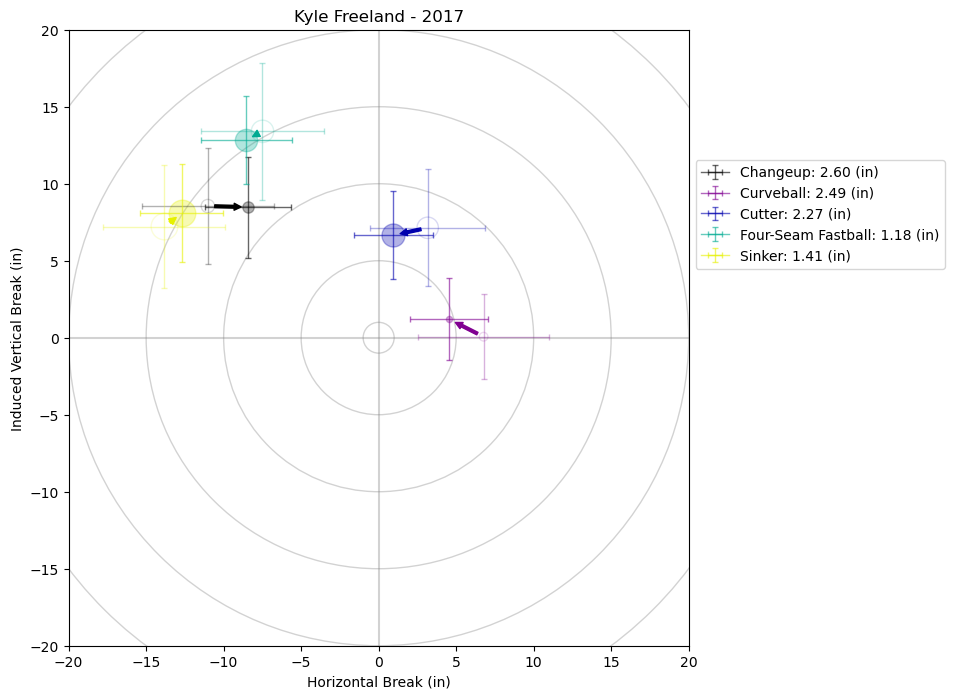

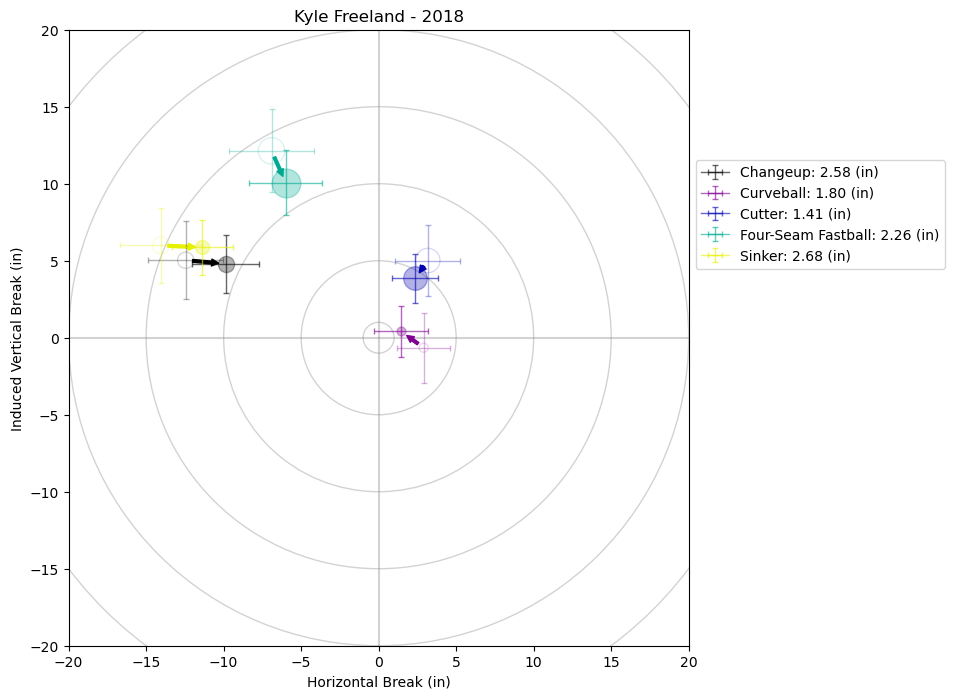

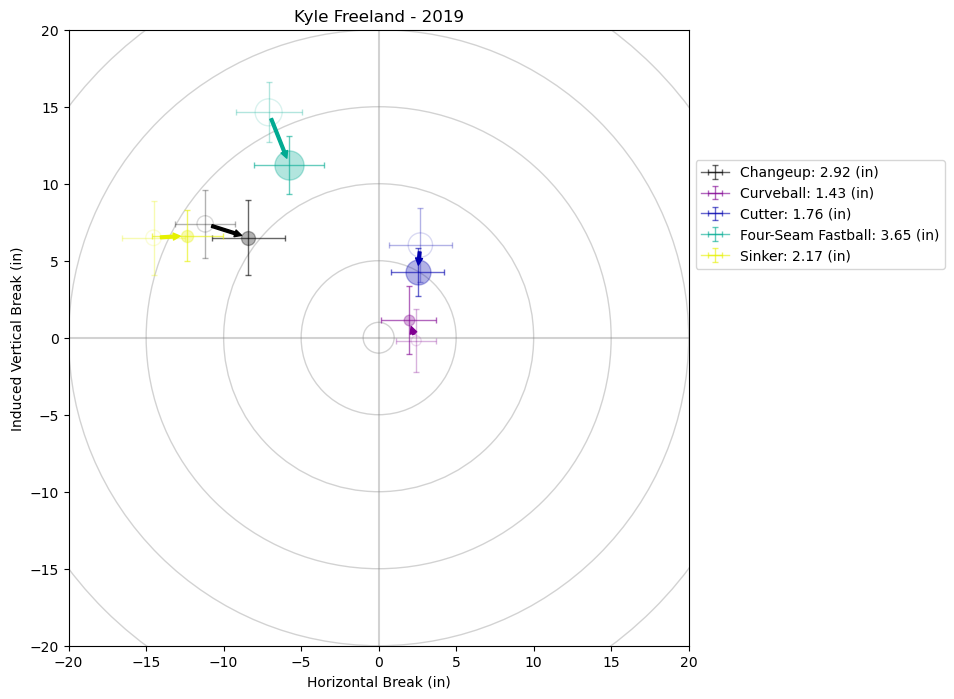

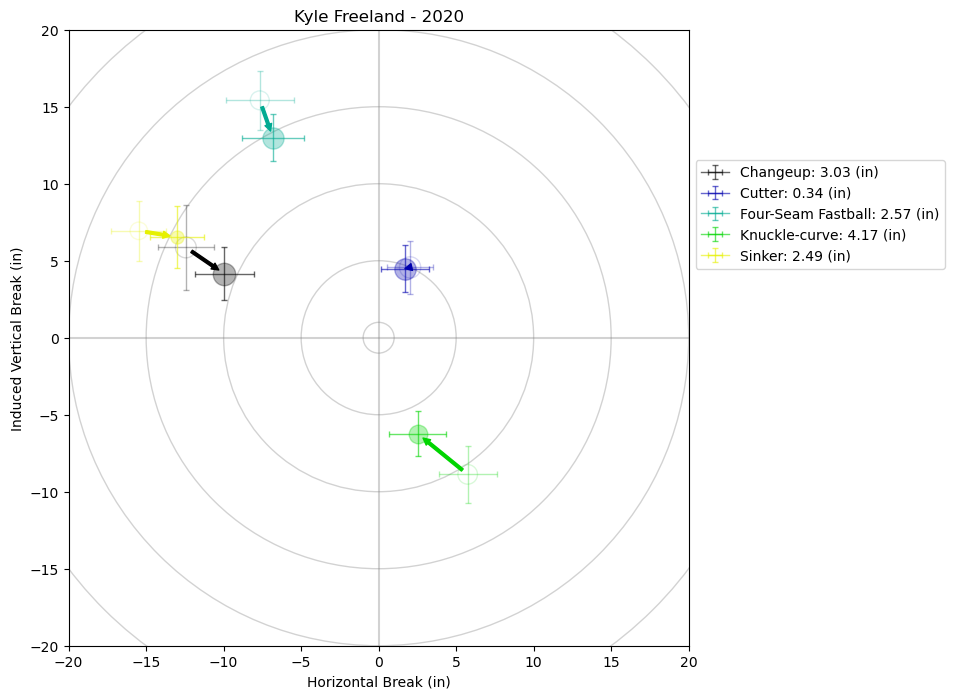

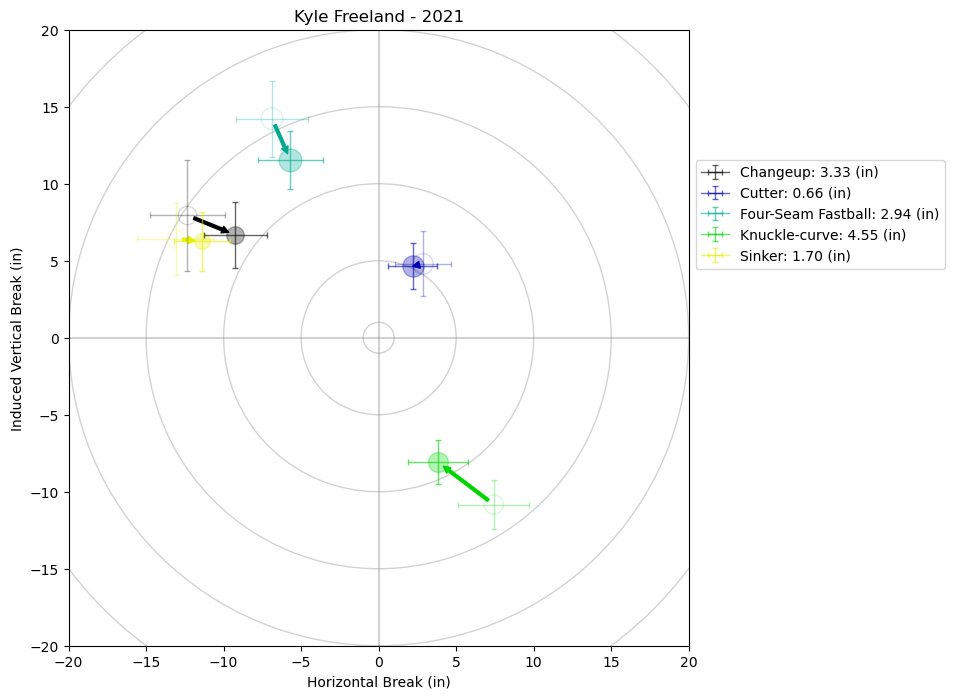

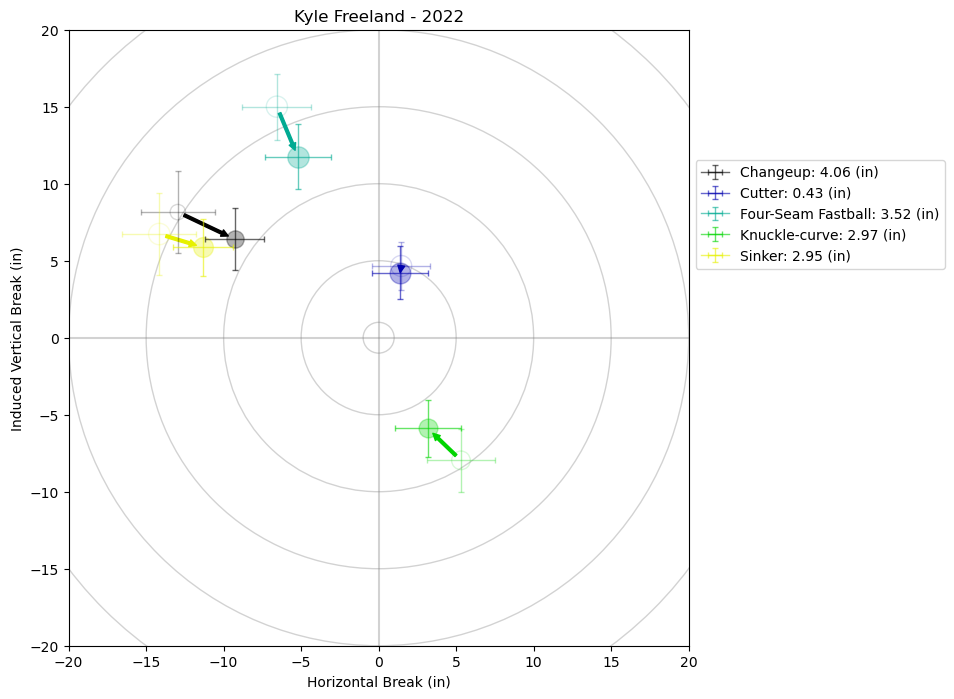

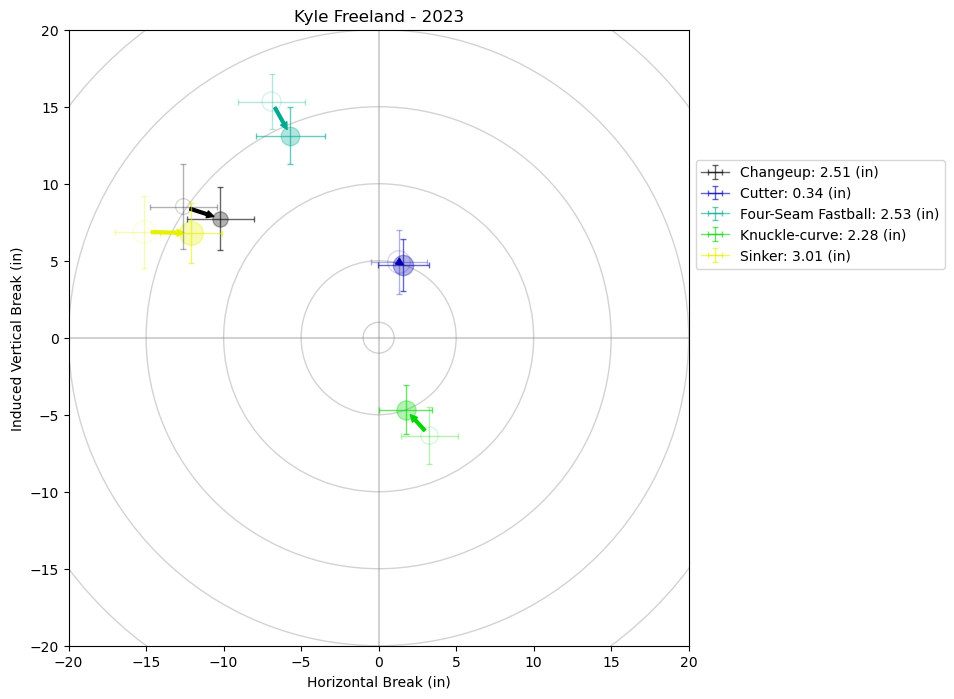

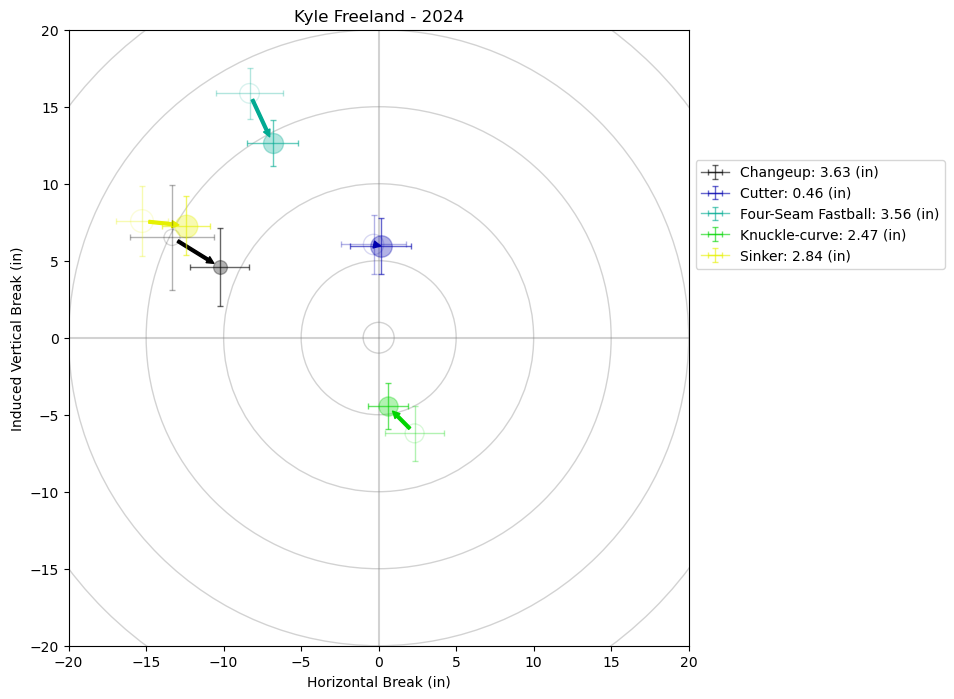

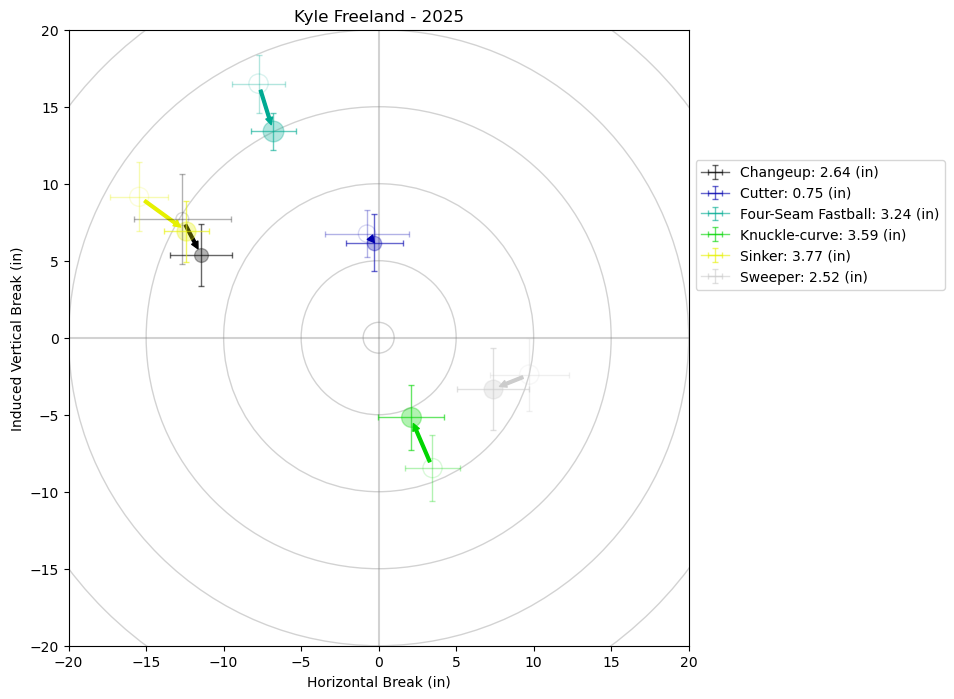

In [9]:
# Make plot
def generate_movement_splits(df: pd.DataFrame, figsize: tuple=(8,8), year: str=None, title=None):

    def add_pitches(loc, pitch):

        # Toggle parameters
        if loc == 'home':
            alpha = 0.6
            facecolors=colors(i)
            linestyle='solid'
            label=mlb_pitch_types[pitch]
        else:
            alpha=0.3
            facecolors='none'
            linestyle='dashed'
            label=None

        # Define x, y
        x = data.loc[pitch, loc]['hb mean']
        y = data.loc[pitch, loc]['ivb mean']

        # Add plots
        ax.errorbar(x=x, 
                    xerr=data.loc[pitch, loc]['hb std'],
                    y=y,
                    yerr=data.loc[pitch, loc]['ivb std'],
                    color=colors(i), 
                    fmt='o', 
                    capsize=2,
                    linestyle=linestyle,
                    linewidth=1,
                    markersize=0,
                    alpha=alpha,
                    label=label)
        
        ax.scatter(x=x, 
                y=y,
                facecolors=facecolors, 
                edgecolors=colors(i),
                s=data.loc[pitch, loc]['usage']*10,
                alpha=alpha/2)

        return x, y

    def add_arrow(x1, y1, x2, y2):

        d = euclidean([x1, y1], [x2, y2])
    
        arrow = matplotlib.patches.FancyArrowPatch((x1, y1), (x2, y2), color=colors(i), mutation_scale=10, alpha=1, shrinkA=5, shrinkB=5)
        ax.add_patch(arrow)

        return d        
        
   
    fig, ax = plt.subplots(figsize=figsize)

    # Parse data according to criteria
    if year is not None:
        data = df.loc[str(year)]
    else:
        raise NotImplementedError()

    # Colors
    mlb_pitch_types = json.load(open('mlb_pitch_types.json', 'r'))
    colors = matplotlib.cm.get_cmap('nipy_spectral').resampled(len(mlb_pitch_types.keys()))
    pitch_types = np.unique([data.index[i][0] for i in range(len(data.index))])

    # Add pitches
    distances = {}
    for i, pitch in enumerate(mlb_pitch_types.keys()):
        if pitch in pitch_types:
            home_x, home_y = add_pitches('home', pitch)
            away_x, away_y = add_pitches('away', pitch)
            distances[pitch] = add_arrow(away_x, away_y, home_x, home_y)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for pitch in mlb_pitch_types.keys():
        if pitch in pitch_types:
            new_labels.append(mlb_pitch_types[pitch] + ': {:.2f} (in)'.format(distances[pitch]))
            
    # Visuals
    ax.plot([0,0], [-20,20], color='grey', alpha=0.35, zorder=-1)  
    ax.plot([-20,20], [0,0], color='grey', alpha=0.35, zorder=-1) 
    for r in [1, 5, 10, 15, 20, 25]:
        circ = matplotlib.patches.Circle((0,0), radius=r, facecolor='none', edgecolor='grey', alpha=0.35, zorder=-1)
        ax.add_patch(circ)
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_ylabel('Induced Vertical Break (in)')
    ax.set_xlabel('Horizontal Break (in)')
    ax.legend(handles, new_labels, bbox_to_anchor=(1,0.8))
    ax.set_title(title)
    plt.show()

    return fig

for year in years:
    fig = generate_movement_splits(df, year=year, title=f'Kyle Freeland - {year}')
    fig.savefig(f'./pitch_data/{last_name}_{first_name}_movement_splits_{year}.png')
